In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm #biblioteca para loading in arquitetura especifica de classificacao de imagens 

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm


C:\Users\antho\AppData\Local\Temp\ipykernel_8292\2564220640.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
PyTorch version 2.2.1+cu118
Torchvision version 0.17.1+cu118
Numpy version 1.26.4
Pandas version 2.2.0


# Set Up in dataset

In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) #aplicando tranforme em cada imagem do dataset
    def __len__(self): #funcao para retornar o tamanho do dataset
        return len(self.data)
    def __getitem__(self, index): #funcao para retorna o objeto para cada posicao
        return self.data[index]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
dataset = PlayingCardDataset(data_dir='./dataset/train')

In [4]:
len(dataset)

7624

In [7]:
image, label = dataset[0]
label

0

In [7]:
# Get a dictionary associating target values with folder names
data_dir = 'dataset/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

#basicamente, criando um dic para associar os numeros dos labels pelos nomes das classes. Que aqui esta nos nomes das pastas

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [8]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

#tranform para deixar todas as imagem em 128x128
#e transformar em tensores

In [9]:
dataset = PlayingCardDataset(data_dir, transform)

In [10]:
image, label = dataset[100]
label

torch.Size([3, 128, 128])

In [11]:
#iterar sobre o dataset
for image, label in dataset:
    break

# DataLoader

In [12]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [13]:
for image, labels in dataloader:
    break

In [14]:
image.shape, labels.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16]))

In [15]:
image

tensor([[[[0.9020, 0.9059, 0.9059,  ..., 0.8784, 0.8824, 0.9059],
          [0.9020, 0.8941, 0.8941,  ..., 0.8745, 0.8824, 0.8980],
          [0.8863, 0.8980, 0.8980,  ..., 0.8902, 0.8980, 0.8980],
          ...,
          [0.8588, 0.8667, 0.8745,  ..., 0.8784, 0.8745, 0.8784],
          [0.8588, 0.8627, 0.8745,  ..., 0.8824, 0.8706, 0.8706],
          [0.8745, 0.8588, 0.8627,  ..., 0.8627, 0.8549, 0.8745]],

         [[0.8902, 0.8941, 0.8980,  ..., 0.9059, 0.9098, 0.9020],
          [0.8941, 0.8941, 0.8902,  ..., 0.8941, 0.8941, 0.8902],
          [0.8902, 0.8902, 0.8941,  ..., 0.8863, 0.8902, 0.8941],
          ...,
          [0.8627, 0.8627, 0.8627,  ..., 0.8627, 0.8706, 0.8706],
          [0.8706, 0.8627, 0.8588,  ..., 0.8667, 0.8667, 0.8667],
          [0.8941, 0.8627, 0.8588,  ..., 0.8667, 0.8706, 0.8824]],

         [[0.8902, 0.8745, 0.8588,  ..., 0.8706, 0.8784, 0.8863],
          [0.8784, 0.8627, 0.8549,  ..., 0.8667, 0.8667, 0.8745],
          [0.8745, 0.8706, 0.8588,  ..., 0

# Modelo Pytorch

In [16]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=3): #Aqui, definimos todas as partes do modelo
        super(SimpleCardClassifer, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280 #padrao do modelo b0
        #fazendo o classificador
        self.classifier = nn.Linear(enet_out_size, num_classes)
    def forward(self,x): #Conecta as partes e retorna a saida
        x = self.features(x)
        output = self.classifier(x)
        return output

In [17]:
model = SimpleCardClassifer(num_classes=53)

In [18]:
# print(model)
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [19]:
teste = model(image)
print(teste.shape) # [tamanho do batch, num de classes] a saida representa a probabilidade de pertecer do obj pertecer a cada classe

torch.Size([16, 53])


# Treinando o modelo

In [20]:
criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
criterion(teste, labels)


tensor(3.8770, grad_fn=<NllLossBackward0>)

## Preparando os datasets para o treino

In [22]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = './dataset/train'
valid_folder = './dataset/valid'
test_folder = './dataset/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Treino de fato

In [23]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Fase de treino
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad() #Zera o gradiente para os tensores nao estorarem, pois acumulam
        outputs = model(images) #passando o tensor no modelo
        loss = criterion(outputs, labels) #calcula a loss function, quao distante eu estou do ideal
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Fase de validacao
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5669054323641225, Validation loss: 0.38659515043474596


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.625273266234528, Validation loss: 0.20455039008608406


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.40950324665461857, Validation loss: 0.22530872394453805


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2954672612152126, Validation loss: 0.14878889520494443


Training loop:   0%|          | 0/477 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.2611715877985685, Validation loss: 0.15603514574819577


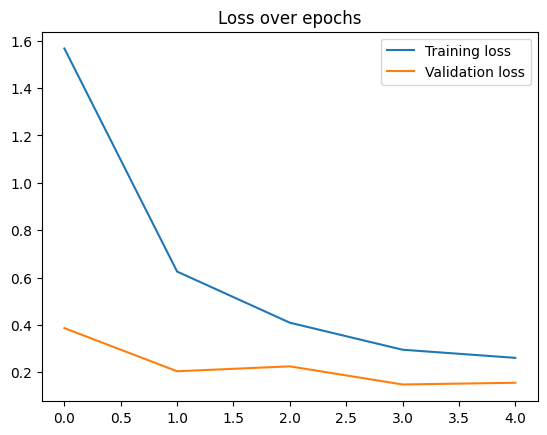

In [27]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

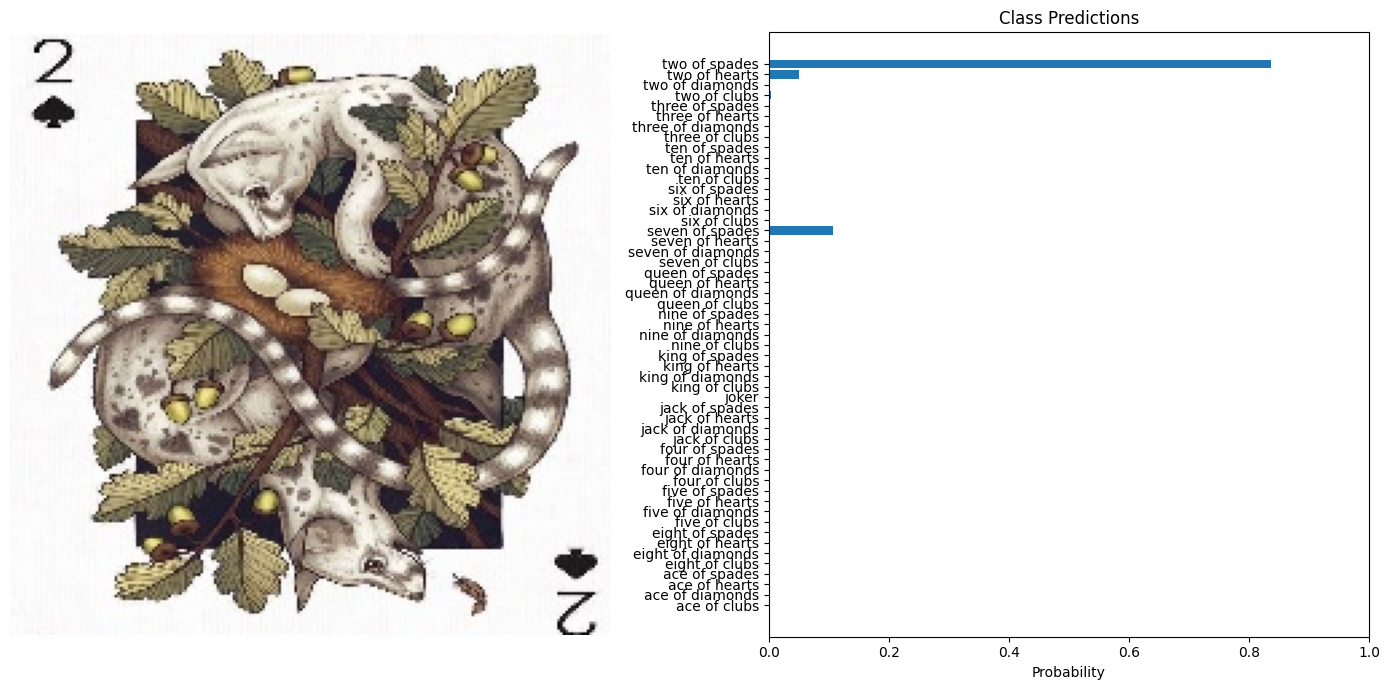

In [31]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "./dataset/test/two of spades/5.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

In [24]:
!pip show ipywidgets

Name: ipywidgets
Version: 8.1.2
Summary: Jupyter interactive widgets
Home-page: http://jupyter.org
Author: Jupyter Development Team
Author-email: jupyter@googlegroups.com
License: BSD 3-Clause License
Location: C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages
Requires: comm, ipython, jupyterlab-widgets, traitlets, widgetsnbextension
Required-by: jupyter


In [25]:
!pip install --upgrade ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [26]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
